In [1]:
!pwd
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.executable

/c/Users/81908/jupyter_notebook/tf_2_work/04.image_relate/tf_image


'C:\\Users\\81908\\Anaconda3\\envs\\tfgpu\\python.exe'

# 犬猫画像でImageDataGenerator+finetuning試す

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

OUTPUT_DIR = r'D:\work\tmp\out_tf_image'

TRAIN_DIR = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
VALID_DIR = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'
TEST_DIR = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test'

IMG_SIZE = 160 # All images will be resized to 160x160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 64
EPOCHS = 5

class DataSet:

    @staticmethod
    def get_image_generator(train_IDG_options: dict):
        train_image_generator = ImageDataGenerator(**train_IDG_options) # Generator for our training data
        validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
        test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

        train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                                   directory=TRAIN_DIR,
                                                                   shuffle=True,
                                                                   target_size=(IMG_SIZE, IMG_SIZE),
                                                                   class_mode='binary')

        valid_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                                        directory=VALID_DIR,
                                                                        shuffle=False,
                                                                        target_size=(IMG_SIZE, IMG_SIZE),
                                                                        class_mode='binary')
        
        test_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                                        directory=TEST_DIR,
                                                                        shuffle=False,
                                                                        target_size=(IMG_SIZE, IMG_SIZE),
                                                                        class_mode='binary')
        return train_data_gen, valid_data_gen, test_data_gen
    
class Model:
    
    @staticmethod
    def get_model(n_class=1):
        """モデル構築"""
        # pre-trained model
        #base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
        base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
        # finetuning
        base_model.trainable = False
        # pooling+出力層
        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(256)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        outputs = tf.keras.layers.Dense(n_class)(x)
        model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
        return model
            
    @staticmethod
    def train(model, train_gen, validation_gen, 
              base_learning_rate=0.01, 
              epochs=EPOCHS):
        """モデルでtrain"""
        # コンパイル
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # from_logits=Trueでactivation='sigmoid'いらない
                      optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
                      metrics=['accuracy'])
        # train
        history = model.fit(train_gen,
                            epochs=epochs,
                            validation_data=validation_gen,
                            callbacks = Model().get_base_cb()
                           )
        return model, history
    
    @staticmethod
    def get_base_cb(output_dir=OUTPUT_DIR, save_weights_only=False):
        """callbackの組み合わせ"""
        cb = []
        # 各エポックでval_lossが最小となるモデル保存
        cb.append(tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'best_val_loss.h5'), monitor='val_loss', save_best_only=True, verbose=1, 
                                                     save_weights_only=save_weights_only))
        # # 各エポックでval_accが最大となるモデル保存
        # cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'best_val_acc.h5'), monitor='val_acc', save_best_only=True, verbose=1, mode='max'))
        # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
        cb.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=EPOCHS//2, verbose=1))
        return cb
    
    @staticmethod
    def plot_hist(history):
        """train結果plot"""
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.ylim([0,1.0])
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()

    @staticmethod
    def predict_gen(model, test_gen):
        """generatorで予測"""
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        import matplotlib.pyplot as plt

        y_true = ["cat" if y < 0.5 else "dog" for y in test_data_gen.classes]
        y_pred = ["cat" if pb < 0.5 else "dog" for pb in model.predict(test_data_gen).reshape(-1)]

        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, cmap='Blues')
        plt.xticks(np.arange(2), ['Cat', 'Dog'], rotation=45)
        plt.yticks(np.arange(2), ['Cat', 'Dog'])
        plt.show()
        

Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 79, 79, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 79, 79, 32)   0           ba

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 16 steps, validate for 7 steps
Epoch 1/5
15/16 [===========================>..] - ETA: 0s - loss: 3.0573 - accuracy: 0.5748
Epoch 00001: val_loss improved from inf to 4.34812, saving model to D:\work\tmp\out_tf_image\best_val_loss.h5
16/16 [==============================] - 13s 815ms/step - loss: 2.9544 - accuracy: 0.5760 - val_loss: 4.3481 - val_accuracy: 0.5550
Epoch 2/5
15/16 [===========================>..] - ETA: 0s - loss: 1.3278 - accuracy: 0.6667
Epoch 00002: val_loss improved from 4.34812 to 1.17003, saving model to D:\work\tmp\out_tf_image\best_val_loss.h5
16/16 [==============================] - 7s 449ms/step - loss: 1.2774 - accuracy: 0.6720 - val_loss: 1.1700 - val_accuracy: 0.8525
Epoch 3/5
15/16 [===========================>..] - ETA: 0s - loss: 1.4801 - accuracy: 0.6132
Epoch 00003: val_loss improved from 1.17003 to 0.54686, saving model to D:\work\tmp\out_tf_image\best_val_loss.h5
16/16 [==============================] - 7s 457ms/step - loss: 1.4439 - accurac

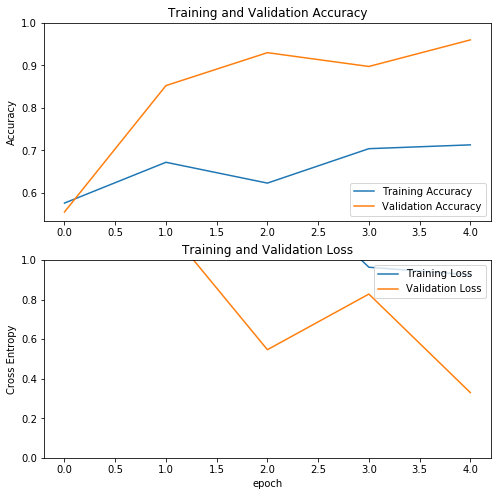

  ...
    to  
  ['...']


  ...
    to  
  ['...']


4/4 [==============================] - 1s 339ms/step - loss: 0.3805 - accuracy: 0.9450
0.38053354517251137 0.945


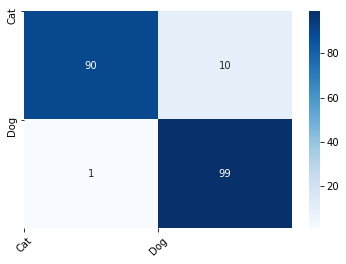

In [5]:
if __name__ == '__main__':
    
    # data
    train_IDG_options = {'rescale': 1.0/255.0, 
                         'width_shift_range': 0.15,
                         'height_shift_range': 0.15,
                         'horizontal_flip': True, 
                         'rotation_range': 45, 
                         'zoom_range': 0.5}
    train_data_gen, valid_data_gen, test_data_gen = DataSet().get_image_generator(train_IDG_options)

    # train
    model = Model().get_model()
    model.summary()
    trained_model, history = Model().train(model, train_data_gen, valid_data_gen)
    Model().plot_hist(history)
    
    # モデル評価
    test_loss, test_acc = model.evaluate(test_data_gen)
    print(test_loss, test_acc)
    
    # predict
    Model().predict_gen(trained_model, test_data_gen)

## EfficientNet でfinetuning
- https://qiita.com/wakame1367/items/d90fa56bd9d11c4db50e

Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1536)              10783528  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1537      
Total params: 10,785,065
Trainable params: 1,537
Non-trainable params: 10,783,528
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 16 steps, validate for 7 steps
Epoch 1/5
15/16 [===========================>..] - ETA: 0s - loss: 0.5017 - accuracy: 0.6496
Epoch 00001: val_loss improved from inf to 0.34069, saving model to D:\work\tmp\out_tf_image\best_val_loss_w.h5
16/16 [==============================] - 15s 957ms/step - loss: 0.4939 - accuracy: 0.6610 - val_loss: 0.3407 - val_accuracy: 0.8400
Epoch 2/5
15/16 [===========================>..] - ETA: 0s - loss: 0.3007 - accuracy: 0.8665
Epoch 00002: val_loss improved from 0.34069 to 0.23293, saving model to D:\work\tmp\out_tf_image\best_val_loss_w.h5
16/16 [==============================] - 7s 457ms/step - loss: 0.2996 - accuracy: 0.8670 - val_loss: 0.2329 - val_accuracy: 0.9125
Epoch 3/5
15/16 [===========================>..] - ETA: 0s - loss: 0.2239 - accuracy: 0.9188
Epoch 00003: val_loss improved from 0.23293 to 0.17574, saving model to D:\work\tmp\out_tf_image\best_val_loss_w.h5
16/16 [==============================] - 7s 452ms/step - loss: 0.2205 - a

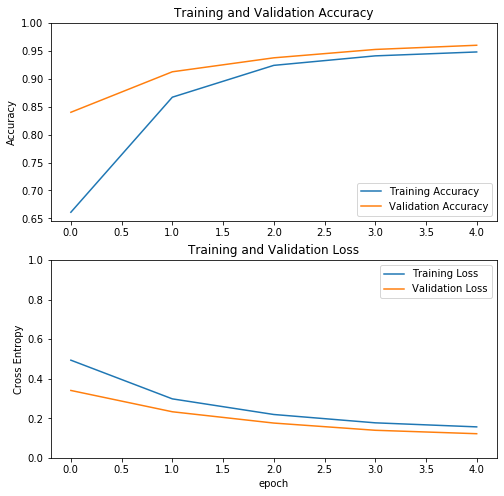

  ...
    to  
  ['...']


  ...
    to  
  ['...']


4/4 [==============================] - 1s 306ms/step - loss: 0.1249 - accuracy: 0.9700
0.12492137774825096 0.97


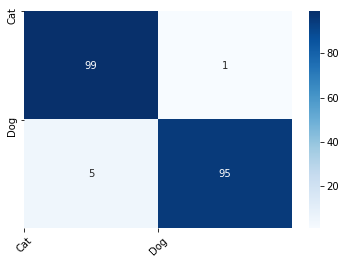

In [6]:
def get_tfhub_efficient_net(n_class=1, b_num='b3'):
    """
    tensorflow hub EfficientNet
    https://qiita.com/wakame1367/items/d90fa56bd9d11c4db50e
    Args:
        n_class: 出力層のnode数
        b_num: b0-b7のいずれか
    """
    import tensorflow as tf
    import tensorflow_hub as hub
    
    feature_extractor_url = f"https://tfhub.dev/google/efficientnet/{b_num}/feature-vector/1"
    feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=IMG_SHAPE)
    feature_extractor_layer.trainable = False  # 学習済み重みは固定
    # Sequentialじゃないとだめ
    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(n_class)
    ])
    return model


def get_base_cb(output_dir=OUTPUT_DIR, save_weights_only=True):
    """callbackの組み合わせ"""
    cb = []
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'best_val_loss_w.h5'), monitor='val_loss', save_best_only=True, verbose=1, 
                                                 save_weights_only=save_weights_only))
    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=EPOCHS//2, verbose=1))
    return cb


def train(model, train_gen, validation_gen, 
          base_learning_rate=0.01, 
          epochs=EPOCHS):
    """モデルでtrain"""
    # コンパイル
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # from_logits=Trueでactivation='sigmoid'いらない
                  optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
                  metrics=['accuracy'])
    # train
    history = model.fit(train_gen,
                        epochs=epochs,
                        validation_data=validation_gen,
                        callbacks = get_base_cb()
                       )
    return model, history


if __name__ == '__main__':
    
    # data
    train_IDG_options = {'rescale': 1.0/255.0, 
                         'width_shift_range': 0.15,
                         'height_shift_range': 0.15,
                         'horizontal_flip': True, 
                         'rotation_range': 45, 
                         'zoom_range': 0.5}
    train_data_gen, valid_data_gen, test_data_gen = DataSet().get_image_generator(train_IDG_options)

    # train
    model = get_tfhub_efficient_net()
    model.summary()
    trained_model, history = train(model, train_data_gen, valid_data_gen)
    Model().plot_hist(history)
    
    # モデル評価
    test_loss, test_acc = model.evaluate(test_data_gen)
    print(test_loss, test_acc)
    
    # predict
    Model().predict_gen(trained_model, test_data_gen)

### EfficientNet は重みからしかロードできない

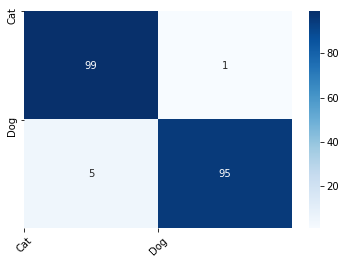

In [7]:
model = get_tfhub_efficient_net()
model.load_weights(OUTPUT_DIR + '/best_val_loss_w.h5')
Model().predict_gen(model, test_data_gen)